<a href="https://colab.research.google.com/github/Beh04/Random-Forest-Regression/blob/main/solu%C3%A7%C3%A3o/Previs%C3%A3o_de_Vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas utilizadas

In [1]:
# Importa as bibliotecas do projeto
from sklearn.model_selection import GridSearchCV # Busca de hiperparâmetros
import pandas as pd # Manipulação de Dataframes
import numpy as np # Funções matemáticas
import matplotlib.pyplot as plt #Gráficos
import seaborn as sns #Gráficos
import time # Tempo de treinamento dos modelos
import plotly.express as px # Gráficos
from sklearn.model_selection import train_test_split # Separação do modelo em base de treino e teste
from sklearn.ensemble import RandomForestRegressor # Modelo de Floresta Regressora
from sklearn.preprocessing import StandardScaler # Padronização dos dados
from sklearn.preprocessing import LabelEncoder # Pré-processamento de dados, varíaveis categóricas em contínuas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # Métricas para avaliação do modelo
import math # Cálculos matemáticos
import warnings # Ignora avisos
warnings.filterwarnings('ignore')

Importação da base de dados

In [2]:
df = pd.read_excel('/content/base_vendas_ano.xlsx')

In [3]:
df.head()

,Ano,ID do Produto,Nome do Produto,Nome da Categoria,Nome da Subcategoria,Marca,Tamanho,Peso,Classe,Preço Unitário,Custo Unitário,Total de Qtd. Vendida
0,2009,1,Contoso 512MB MP3 Player E51 Silver,Audio,MP4&MP3,Contoso,2.2 x 1.8 x 4,4.8,Economy,12.99,6.62,8200
1,2009,2,Contoso 512MB MP3 Player E51 Blue,Audio,MP4&MP3,Contoso,2.2 x 1.8 x 4,4.1,Economy,12.99,6.62,7706
2,2009,3,Contoso 1G MP3 Player E100 White,Audio,MP4&MP3,Contoso,2.2 x 2.2 x 4,4.5,Economy,14.52,7.40,8300
3,2009,4,Contoso 2G MP3 Player E200 Silver,Audio,MP4&MP3,Contoso,2.2 x 2.2 x 4,4.5,Economy,21.57,11.00,8108
4,2009,5,Contoso 2G MP3 Player E200 Red,Audio,MP4&MP3,Contoso,3.7 x 0.6 x 2.2,2.4,Economy,21.57,11.00,8518


# Análise Exploratória

In [4]:
# Temos 1946 produtos para fazermos a previsão nesta base
df.shape

(1946, 12)

In [5]:
# Tipos de dados, Ok
df.dtypes

Ano                        int64
ID do Produto              int64
Nome do Produto           object
Nome da Categoria         object
Nome da Subcategoria      object
Marca                     object
Tamanho                   object
Peso                     float64
Classe                    object
Preço Unitário           float64
Custo Unitário           float64
Total de Qtd. Vendida      int64
dtype: object

In [6]:
# Sem valores nulos em nossa base
df.isnull().sum()

Ano                      0
ID do Produto            0
Nome do Produto          0
Nome da Categoria        0
Nome da Subcategoria     0
Marca                    0
Tamanho                  0
Peso                     0
Classe                   0
Preço Unitário           0
Custo Unitário           0
Total de Qtd. Vendida    0
dtype: int64

In [7]:
# Verificando valores duplicados
df.duplicated().sum()

0

In [8]:
# Verificando valores únicos
df.nunique()

Ano                         1
ID do Produto            1946
Nome do Produto          1946
Nome da Categoria           8
Nome da Subcategoria       25
Marca                      14
Tamanho                   628
Peso                      263
Classe                      3
Preço Unitário            326
Custo Unitário            356
Total de Qtd. Vendida    1413
dtype: int64

Como só temos um valor único no ano, vamos retirar essa informação

In [9]:
df.drop('Ano', axis=1, inplace=True)

In [10]:
#Aqui temos as principais medidas das nossas varíaveis contínuas
df.describe()

,ID do Produto,Peso,Preço Unitário,Custo Unitário,Total de Qtd. Vendida
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,1392.586845,23.354394,372.240031,153.837518,7405.582734
std,705.549804,39.094427,519.407073,195.001463,16321.657297
min,1.000000,0.170000,3.350000,1.710000,1011.000000
25%,810.250000,3.900000,79.950000,40.760000,3949.250000
50%,1417.500000,7.000000,209.000000,90.550000,4320.000000
75%,2023.750000,25.000000,422.000000,183.540000,8173.500000
max,2517.000000,239.000000,3199.990000,1060.220000,189120.000000


Desconsiderando o ID do Produto, temos um alto desvio padrão na nossa variável  que será prevista

In [11]:
px.box(df['Total de Qtd. Vendida'])

# Pré-processamento

In [12]:
# Verificando tipos de dados
df.dtypes

ID do Produto              int64
Nome do Produto           object
Nome da Categoria         object
Nome da Subcategoria      object
Marca                     object
Tamanho                   object
Peso                     float64
Classe                    object
Preço Unitário           float64
Custo Unitário           float64
Total de Qtd. Vendida      int64
dtype: object

Vamos retirar a variável "Nome do  Produto", pois já está representada na variável "ID do Produto"

In [13]:
base = df.copy().drop('Nome do Produto', axis=1)

lb = LabelEncoder()

# Aplica o encoder nas variáveis que estão com string
encoder = ['Nome da Categoria',
           'Nome da Subcategoria',
           'Marca',
           'Tamanho',
           'Classe']

# Loop para conversão das colunas categóricas em númericas
for coluna in encoder:
    base[coluna] = lb.fit_transform(base[coluna])

In [14]:
base.dtypes

ID do Produto              int64
Nome da Categoria          int64
Nome da Subcategoria       int64
Marca                      int64
Tamanho                    int64
Peso                     float64
Classe                     int64
Preço Unitário           float64
Custo Unitário           float64
Total de Qtd. Vendida      int64
dtype: object

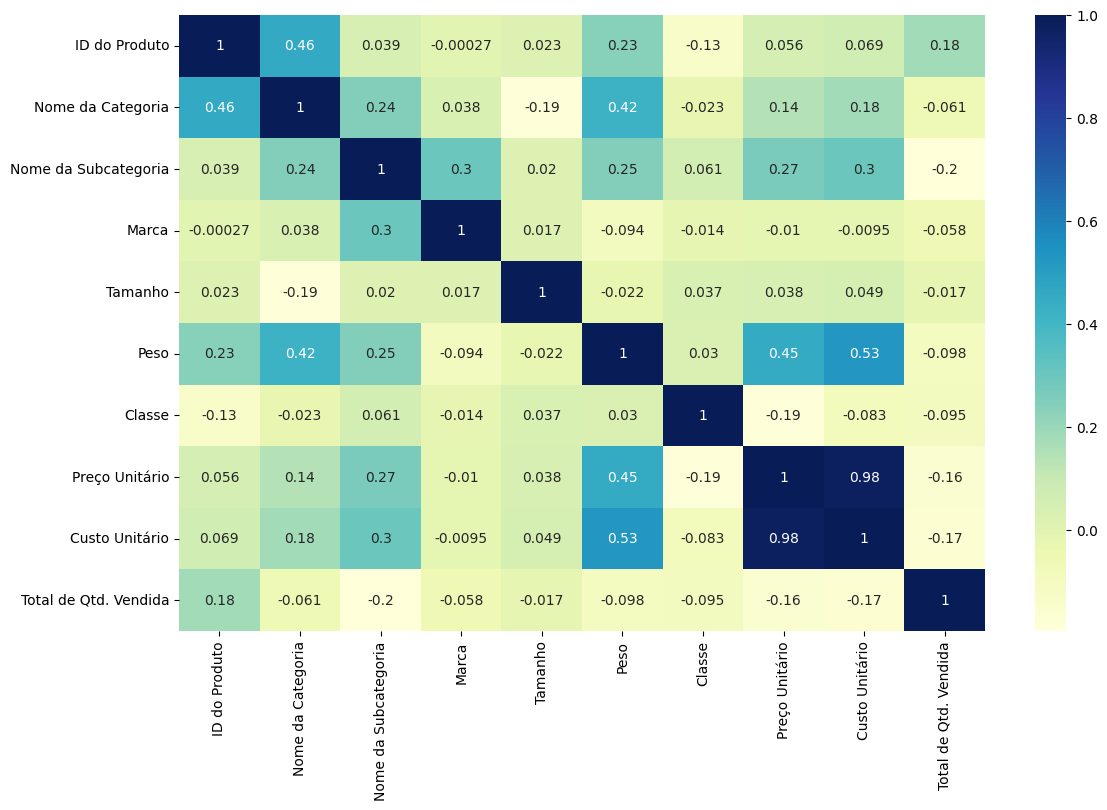

In [15]:
# Mostrando a correlação entre as variáveis
plt.figure(figsize=(13,8))
sns.heatmap(base.corr(),annot=True,cmap="YlGnBu")
plt.show()

# Modelagem

## Divisão da base e padronização dos dados

In [16]:
# Separando X e Y
X = base.iloc[:,0:9]
y = base.iloc[:,9]

In [17]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [18]:
# Padronização da nossa base
Padronizador = StandardScaler()
X_treino_padrozinado = Padronizador.fit_transform(X_train)
X_teste_padronizado = Padronizador.transform(X_test)

In [19]:
X_treino_padrozinado = pd.DataFrame(X_treino_padrozinado)

X_treino_padrozinado.columns = ['ID do Produto',
                                'Nome da Categoria',
                                'Nome da Subcategoria',
                                'Marca',
                                'Tamanho',
                                'Peso',
                                'Classe',
                                'Preço Unitário',
                                'Custo Unitário']

X_treino_padrozinado.head()

,ID do Produto,Nome da Categoria,Nome da Subcategoria,Marca,Tamanho,Peso,Classe,Preço Unitário,Custo Unitário
0,-0.283124,-1.194004,-1.400336,-0.098406,-0.505538,-0.534856,-0.549169,-0.396368,-0.355294
1,1.197546,0.812453,0.137651,1.928489,-1.284954,-0.277205,0.835957,-0.035801,0.040847
2,1.316729,0.812453,0.137651,0.154956,-1.642186,-0.236389,-0.549169,-0.557616,-0.572820
3,0.845607,0.812453,0.445248,-0.351767,-1.831627,0.350342,0.835957,-0.315815,-0.299860
4,0.685762,0.812453,1.675638,-0.858491,0.825963,2.161554,-1.934294,4.623370,3.893362


In [20]:
X_teste_padronizado = pd.DataFrame(X_teste_padronizado)

X_teste_padronizado.columns = ['ID do Produto',
                               'Nome da Categoria',
                               'Nome da Subcategoria',
                               'Marca',
                               'Tamanho',
                               'Peso',
                               'Classe',
                               'Preço Unitário',
                               'Custo Unitário']

X_teste_padronizado.head()

,ID do Produto,Nome da Categoria,Nome da Subcategoria,Marca,Tamanho,Peso,Classe,Preço Unitário,Custo Unitário
0,1.097994,0.812453,-0.938940,-0.351767,-0.922309,0.069731,-1.934294,2.605000,2.123840
1,0.806347,0.812453,1.214242,0.154956,-0.359398,1.319723,-0.549169,-0.456819,-0.436846
2,0.036566,-0.692390,1.521840,1.675127,-0.624616,-0.516999,0.835957,-0.198963,-0.157650
3,0.150140,-0.692390,1.368041,1.675127,-1.772089,-0.450673,-0.549169,-0.458813,-0.439511
4,-1.068328,-0.190775,0.906645,1.928489,1.486301,-0.450673,-0.549169,-0.335938,-0.324379


## Treinamento dos modelos

In [21]:
# Treinamento usando random forest
randomForest = RandomForestRegressor()

In [ ]:
# Treinamento de Random Forest no Grid Search
n_estimators = [100, 200, 300, 400, 500, 600]
max_depth = [10, 20, None]
criterion = ["squared_error", "absolute_error"]
max_features = ["sqrt", "log2", None]
min_samples_split = [2, 5]  # O valor 1 não é válido para min_samples_split
min_samples_leaf = [1, 2, 3]


# Grid de hiperparâmetros
grid_parametros = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterion,
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

# Criando o modelo com o Grid de Hiperparametros
randomForest = GridSearchCV(randomForest, grid_parametros, cv = 3, n_jobs = 8)

# Treinando os modelos
inicio = time.time()
randomForest.fit(X_treino_padrozinado, y_train)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

# Acurácia em Treino
print(f"Score em Treinamento: {randomForest.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {randomForest.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_rf.shape[0])

Score em Treinamento: 92.04%

Hiperparâmetros Ideais: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Tempo de Treinamento do Modelo:  7621.9

Numero de treinamentos realizados:  648


In [22]:
# Criando o regressor com Random Forest Regressor
rfr = RandomForestRegressor(n_estimators  = 100, criterion = 'absolute_error', max_depth = None,
                             max_features = None, min_samples_leaf = 1, min_samples_split = 2)

# Construção do modelo
rfr = rfr.fit(X_treino_padrozinado, y_train)

In [ ]:
# Dicionário de métricas e metadados
modelo_rf = {'Melhores Hiperparametros':randomForest.best_params_,
               'Número de Modelos Treinados': treinos_rf.shape[0],
               'Melhor Score': str(round(randomForest.best_score_ * 100,2))+"%"}
modelo_rf

{'Melhores Hiperparametros': {'criterion': 'absolute_error',
  'max_depth': None,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 'Número de Modelos Treinados': 648,
 'Melhor Score': '92.04%'}

In [23]:
# Previsão nos dados para teste
y_pred_teste = rfr.predict(X_teste_padronizado)

print(mean_absolute_error(y_test,y_pred_teste))
print(math.sqrt(mean_squared_error(y_test,y_pred_teste)))

#Coeficiente de determinação
print(r2_score(y_test, y_pred_teste))

556.2669606164383
1854.4126908292335
0.989560745789258


Tivemos ótimas métricas com um erro bem baixo e um coeficiente de determinação ótimo

In [24]:
# Colocando as previsões na base principal
base_padronizada = Padronizador.fit_transform(X)

previsoes = rfr.predict(base_padronizada)

print(mean_absolute_error(y,previsoes))
print(math.sqrt(mean_squared_error(y,previsoes)))

#Coeficiente de determinação
print(r2_score(y, previsoes))

1046.4675719424463
7490.82514479907
0.7892565720821195


## Colocando as previsões na base

In [25]:
df['Previsões de Vendas'] = np.round(previsoes, 0).astype(int)

In [26]:
#Coeficiente de determinação
r2 = r2_score(df['Total de Qtd. Vendida'], df['Previsões de Vendas'])

r2_percent = round(r2 * 100, 2)

print(f"Coeficiente de Determinação (R²): {r2_percent}%")

Coeficiente de Determinação (R²): 78.93%


In [27]:
# Assim, ficou nossa base final com as previsões com resultados de um ótimo modelo de regressão preditivo
df.head(10)

,ID do Produto,Nome do Produto,Nome da Categoria,Nome da Subcategoria,Marca,Tamanho,Peso,Classe,Preço Unitário,Custo Unitário,Total de Qtd. Vendida,Previsões de Vendas
0,1,Contoso 512MB MP3 Player E51 Silver,Audio,MP4&MP3,Contoso,2.2 x 1.8 x 4,4.8,Economy,12.99,6.62,8200,8103
1,2,Contoso 512MB MP3 Player E51 Blue,Audio,MP4&MP3,Contoso,2.2 x 1.8 x 4,4.1,Economy,12.99,6.62,7706,7965
2,3,Contoso 1G MP3 Player E100 White,Audio,MP4&MP3,Contoso,2.2 x 2.2 x 4,4.5,Economy,14.52,7.40,8300,8087
3,4,Contoso 2G MP3 Player E200 Silver,Audio,MP4&MP3,Contoso,2.2 x 2.2 x 4,4.5,Economy,21.57,11.00,8108,8157
4,5,Contoso 2G MP3 Player E200 Red,Audio,MP4&MP3,Contoso,3.7 x 0.6 x 2.2,2.4,Economy,21.57,11.00,8518,8333
5,6,Contoso 2G MP3 Player E200 Black,Audio,MP4&MP3,Contoso,1.6 x 0.4 x 3.7,8.8,Economy,21.57,11.00,8148,8156
6,7,Contoso 2G MP3 Player E200 Blue,Audio,MP4&MP3,Contoso,2.2 x 1.5 x 0.6,2.1,Economy,21.57,11.00,8574,8296
7,8,Contoso 4G MP3 Player E400 Silver,Audio,MP4&MP3,Contoso,0.8 x 3.6 x 1.1,5.6,Economy,59.99,30.58,7992,8015
8,9,Contoso 4G MP3 Player E400 Black,Audio,MP4&MP3,Contoso,3.1 x 1.9 x 0.3,2.1,Economy,59.99,30.58,8324,8384
9,10,Contoso 4G MP3 Player E400 Green,Audio,MP4&MP3,Contoso,2.3 x 0.3 x 4,11.0,Economy,59.99,30.58,8172,8192
